# ガウス過程回帰モデルの実装
ライブラリのインポート

In [290]:
# coding: utf-8
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import os
import sklearn 
from sklearn.model_selection import train_test_split

matplotlib.style.use('ggplot')

In [291]:
path = os.getcwd() # 現在のカレントディレクトリを確認
print(path)

/home/taichi/ドキュメント/code/Gaussian_process


In [292]:
# パラメータ値
Theta_1 = 1.0
Theta_2 = 2.0
Theta_3 = 0.01
alpha = 7.5e-13

## データの生成

In [293]:
np.random.seed(121)
#時間データの生成
times = pd.date_range(start="2010-04" , end = "2020-04")
#時系列データを作成（ランダムウォーク）
time_len = len(times)
random = np.random.randint(-1 , 2 , time_len)

def data(random , times): # 時間データと乱数を引数に
    datas = np.zeros(time_len)
    for j in range(time_len):
        if j == 0:
            datas[j] = random[j]
        else :
            datas[j] = datas[j-1] + random[j]
    return datas

%time data = data(random , times)

CPU times: user 1.2 ms, sys: 0 ns, total: 1.2 ms
Wall time: 1.2 ms


In [294]:
df = pd.DataFrame(data , index = times,columns = ["random_walk"])
df.head()

,random_walk
2010-04-01,1.0
2010-04-02,1.0
2010-04-03,0.0
2010-04-04,-1.0
2010-04-05,-1.0


In [295]:
df["random_walk"]

2010-04-01    1.0
2010-04-02    1.0
2010-04-03    0.0
2010-04-04   -1.0
2010-04-05   -1.0
             ... 
2020-03-28   -4.0
2020-03-29   -3.0
2020-03-30   -2.0
2020-03-31   -3.0
2020-04-01   -4.0
Freq: D, Name: random_walk, Length: 3654, dtype: float64

In [296]:
random

array([ 1,  0, -1, ...,  1, -1, -1])

Text(0.5, 1.0, 'random_walk_1dim')

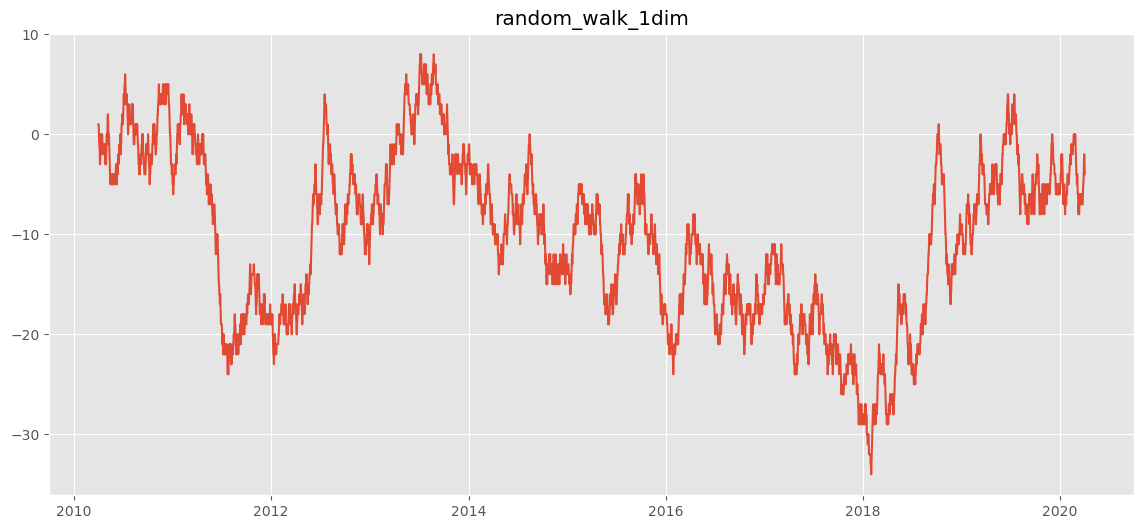

In [297]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(14, 6))

Y = df["random_walk"]
ax.plot(Y)
ax.set_title("random_walk_1dim")

データを月ごとに平均化し，可視化します．

In [298]:
Dataset = df.groupby(pd.Grouper(freq='M')).mean() # freq='M'は月ごと

In [299]:
Dataset.head()

,random_walk
2010-04-30,-1.200000
2010-05-31,-2.677419
2010-06-30,-1.966667
2010-07-31,2.645161
2010-08-31,0.096774


Text(0.5, 1.0, 'Train')

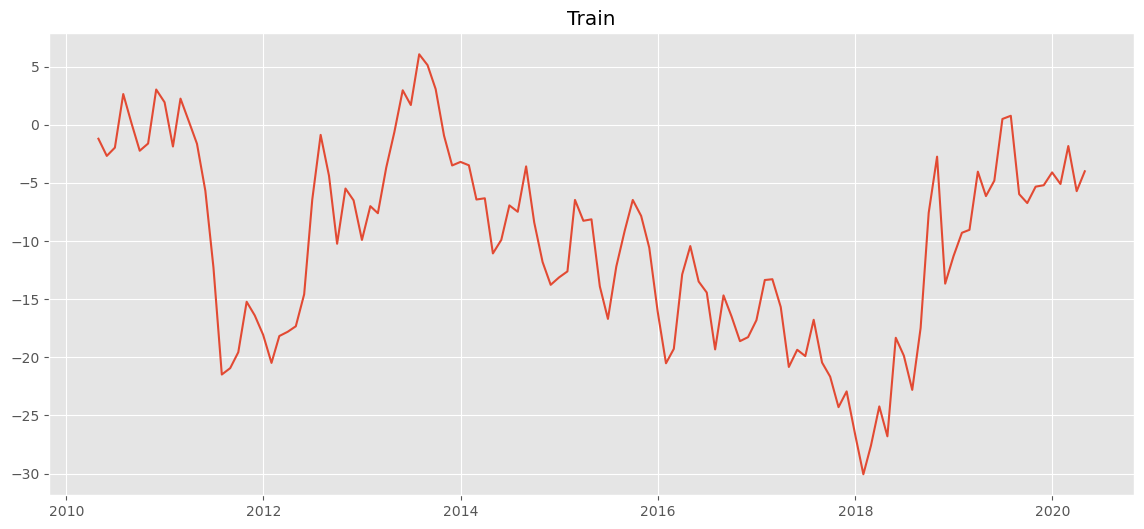

In [300]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(14, 6))

Y = Dataset["random_walk"]
ax.plot(Y)
ax.set_title("Train")

In [301]:
x = pd.DataFrame(np.arange(0 , len(Dataset)),index=Dataset.index ,columns = ["x"])
x.head()

,x
2010-04-30,0
2010-05-31,1
2010-06-30,2
2010-07-31,3
2010-08-31,4


In [302]:
Dataset0 = pd.concat([x , Dataset] , axis =1 )
Dataset0.head()

,x,random_walk
2010-04-30,0,-1.200000
2010-05-31,1,-2.677419
2010-06-30,2,-1.966667
2010-07-31,3,2.645161
2010-08-31,4,0.096774


データを訓練データと交差検証データ，テストデータの3つに分けます．

In [303]:
X , y = Dataset0["x"] , Dataset0["random_walk"]

In [304]:
# データの分割
def data_split(X,y):
    X_train , X_cross , y_train, y_cross = train_test_split(X , y ,random_state=123 , test_size=0.5)
    X_cross , X_test , y_cross, y_test = train_test_split(X_cross , y_cross ,random_state=123 , test_size=0.4)
    return X_train , X_cross , X_test , y_train , y_cross , y_test

In [305]:
X_train , X_cross , X_test , y_train , y_cross , y_test = data_split(X,y)

In [306]:
print(len(X_train))
print(len(y_train))
print(len(X_cross))
print(len(y_cross))
print(len(X_test))
print(len(y_test))

60
60
36
36
25
25


In [307]:
# データを扱いやすいように定義
def data_def(X,y):
    D_x = pd.DataFrame(X ,index = X.index , columns = ["x"])
    D_y = pd.DataFrame(y ,index = y.index , columns = ["random_walk"])
    D0 = pd.concat([D_x , D_y] , axis =1 ) 
    D = D0.sort_values(by = "x")
    return D

def cross_def(X,y):
    D_x = pd.DataFrame(X ,index = X.index , columns = ["x"])
    D_y = pd.DataFrame(y ,index = y.index , columns = ["random_walk"])
    D = pd.concat([D_x , D_y] , axis =1 ) 
    return D

In [308]:
D_train =  data_def(X_train , y_train)
D_cross =  cross_def(X_cross , y_cross)
D_test =  data_def(X_test , y_test)

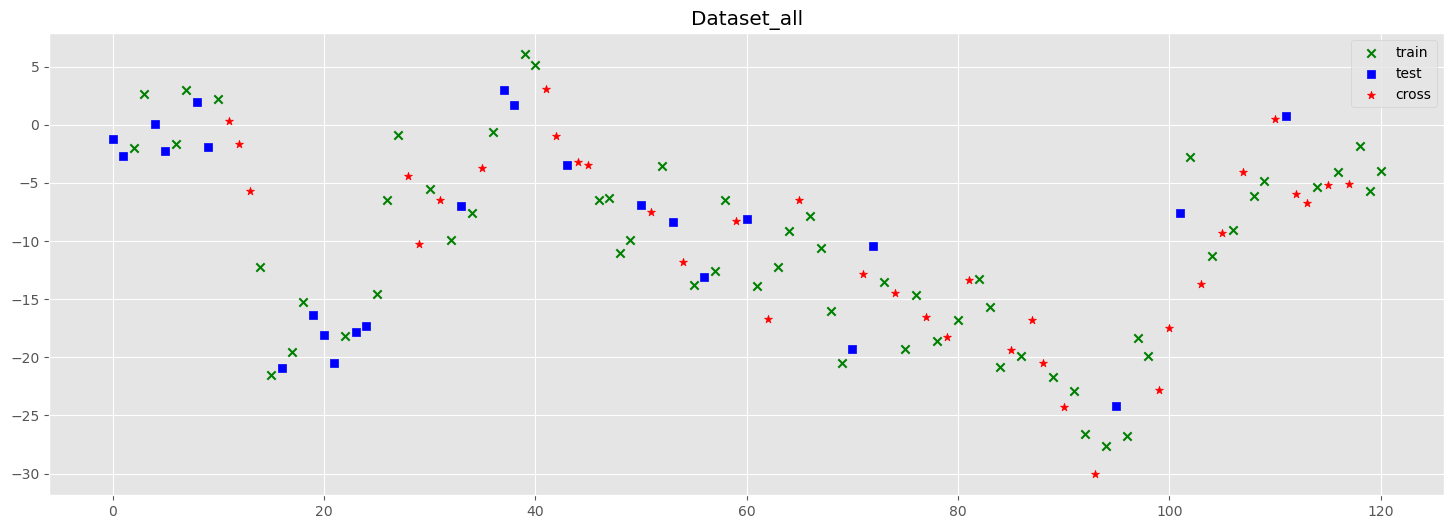

In [309]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(18, 6))

train_x = D_train["x"]
train_y = D_train["random_walk"]
cross_x = D_cross["x"]
cross_y = D_cross["random_walk"]
test_x = D_test["x"]
test_y = D_test["random_walk"]
ax.scatter(train_x , train_y,marker='x' , label = 'train',color='green')
ax.scatter(test_x , test_y,marker='s' ,label = 'test',color='blue')
ax.scatter(cross_x , cross_y ,marker = '*' , label = 'cross' ,color='red')
ax.set_title("Dataset_all")

ax.legend()
plt.show()

# 教科書3.4と3.5のモデルをそのまま採用したコード

## ガウス過程回帰の実装
教科書P81の内容にそってガウス過程回帰の実装を行います．

参考

https://qiita.com/ogi-iii/items/cf16e13ec09340016121

時系列解析

https://qiita.com/DS27/items/1e998a58488e76bfcbdc

### カーネルの学習

データセット$\mathcal{D} = \{ (x_n , y_n ) \} _{n = 1,...,N}$が与えられています．

このデータセットからカーネルを計算し，$\vec{y}$の分布を算出します．

In [310]:
# データセットD
D_train.head()

,x,random_walk
2010-06-30,2,-1.966667
2010-07-31,3,2.645161
2010-10-31,6,-1.612903
2010-11-30,7,3.033333
2011-02-28,10,2.250000


In [311]:
# データ変数名の定義
X_train , y_train = D_train["x"] , D_train["random_walk"]

Text(0.5, 1.0, 'Dataset_Train')

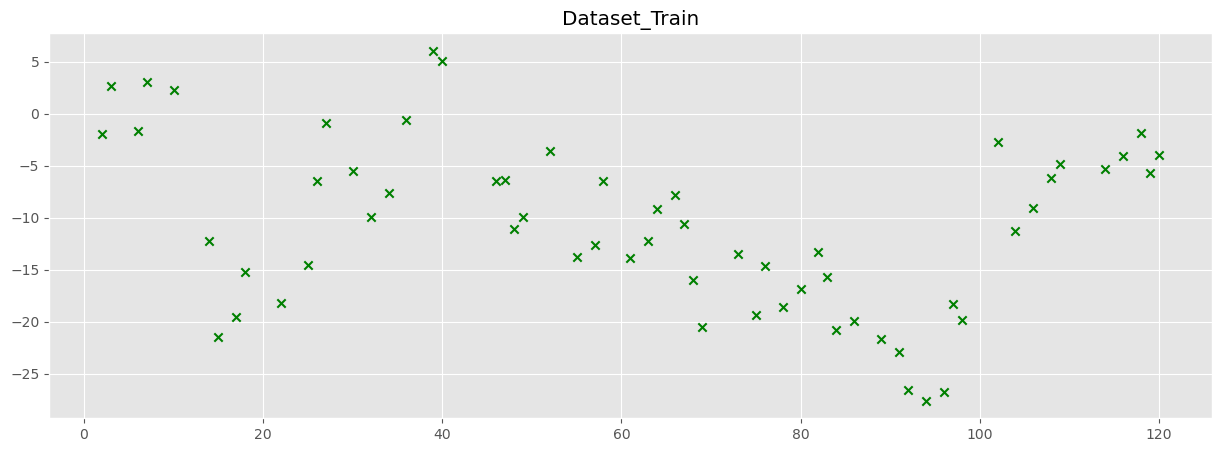

In [312]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(15, 5))

ax.scatter(X_train , y_train , marker='x' , color='green')
ax.set_title("Dataset_Train")

このとき$y_n = f(x_n)$という関係が成り立つとしましょう．

そして，$f$はガウス過程
$$
f～GP(\vec{0} , k(\vec{x},\vec{x}^{'} ))
$$

このとき$y$についてデータをN個を並べたベクトル$\vec{y}$の分布は
$$
\vec{y}～\mathcal{N} (\vec{0} , K)
$$
となります．

ただし，今回カーネルは以下のように定義します．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

まず学習するのは，$\vec{y}$の分布です．

In [313]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) 
    return kernel

In [314]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3)
    return K

In [315]:
%time  K = compute_kernel(X_train , Theta_1 , Theta_2 , Theta_3)
K.shape

CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 19.5 ms


(60, 60)

In [316]:
y

2010-04-30   -1.200000
2010-05-31   -2.677419
2010-06-30   -1.966667
2010-07-31    2.645161
2010-08-31    0.096774
                ...   
2019-12-31   -4.096774
2020-01-31   -5.096774
2020-02-29   -1.827586
2020-03-31   -5.709677
2020-04-30   -4.000000
Freq: M, Name: random_walk, Length: 121, dtype: float64

今後の予測分布などで使う$K^{-1}\vec{y}$を計算しておきます

In [317]:
# K^{-1} * y を計算する関数
def Expected_train(K , y):
    yy = np.dot(np.linalg.inv(K), y) # np.linalg.invは逆行列
    return yy
np.linalg.inv(K)

array([[ 1.54869958e+00, -9.30194604e-01,  1.49135909e-02, ...,
        -1.28298451e-65,  9.45141530e-66, -3.97607198e-66],
       [-9.30194604e-01,  1.54898206e+00, -2.56852922e-02, ...,
         2.21140551e-65, -1.62908529e-65,  6.85332321e-66],
       [ 1.49135909e-02, -2.56852922e-02,  1.54907741e+00, ...,
        -1.38189227e-63,  1.01800432e-63, -4.28259509e-64],
       ...,
       [-1.28298451e-65,  2.21140551e-65, -1.38189227e-63, ...,
         1.82308636e+00, -1.47895984e+00,  6.43945061e-01],
       [ 9.45141530e-66, -1.62908529e-65,  1.01800432e-63, ...,
        -1.47895984e+00,  2.74863436e+00, -1.45250799e+00],
       [-3.97607198e-66,  6.85332321e-66, -4.28259509e-64, ...,
         6.43945061e-01, -1.45250799e+00,  1.77610530e+00]])

In [318]:
yy = Expected_train(K , y_train)
np.dot(yy,yy)

7321.703588806623

分散共分散行列の可視化をしましょう．ヒートマップで行列$K$の値を比較してみましょう．

ヒートマップの作り方

https://dreamer-uma.com/matplotlib-imshow/

In [319]:
K

array([[1.01000000e+00, 6.06530660e-01, 3.35462628e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.06530660e-01, 1.01000000e+00, 1.11089965e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.35462628e-04, 1.11089965e-02, 1.01000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.01000000e+00, 6.06530660e-01, 1.35335283e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.06530660e-01, 1.01000000e+00, 6.06530660e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.35335283e-01, 6.06530660e-01, 1.01000000e+00]])

In [320]:
K_1 = K.copy()

In [321]:
for j in range(len(X_train)):
    K_1[j , j] = 0

K_1

array([[0.00000000e+00, 6.06530660e-01, 3.35462628e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.06530660e-01, 0.00000000e+00, 1.11089965e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.35462628e-04, 1.11089965e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.06530660e-01, 1.35335283e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.06530660e-01, 0.00000000e+00, 6.06530660e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.35335283e-01, 6.06530660e-01, 0.00000000e+00]])

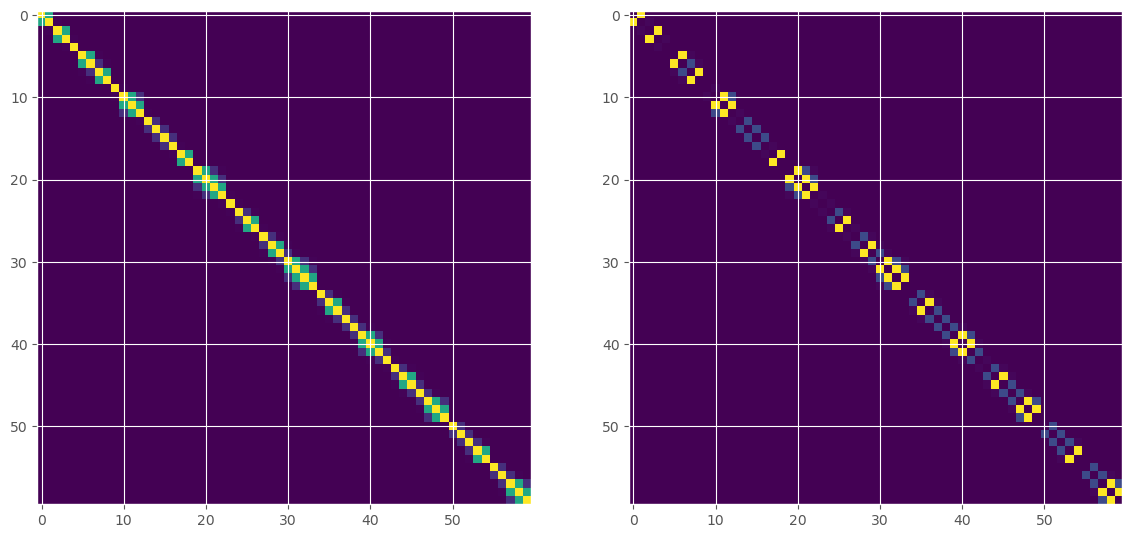

In [322]:
fig, axes = plt.subplots(figsize=(14, 14) , ncols = 2)
im_1 = axes[0].imshow(K)
im_2 = axes[1].imshow(K_1)
plt.show()

このような分散共分散行列をもつ$\vec{y}$の分布が学習できました．

### テストデータへのあてはめ
一旦テストデータへあてはめをしましょう．

その後パラメータの更新を更新して，よりよいモデルを作ってみます．

In [323]:
D_test.head()

,x,random_walk
2010-04-30,0,-1.200000
2010-05-31,1,-2.677419
2010-08-31,4,0.096774
2010-09-30,5,-2.233333
2010-12-31,8,1.935484


In [324]:
X_test ,y_test = D_test["x"] , D_test["random_walk"]

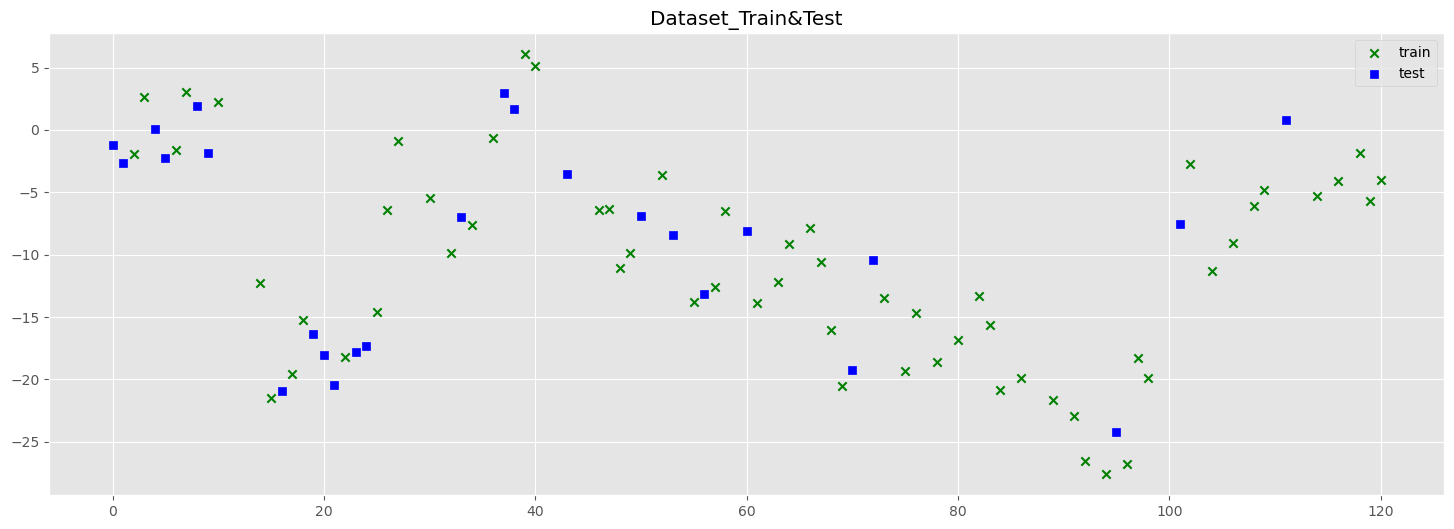

In [325]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(18, 6))

ax.scatter(X_train , y_train,marker='x' , label = 'train',color='green')
ax.scatter(X_test , y_test,marker='s' ,label = 'test',color='blue')
ax.set_title("Dataset_Train&Test")

ax.legend()
plt.show()

予測したいテストデータ$X^{*} = (x^{*}_1 , ... ,x^{*}_M)$と予測したい出力 $\vec{y}^{*} = (y^{*}_1 , ... ,y^{*}_M)$とする．

教科書P84の公式3.8より$\vec{y}^{*}$の予測分布は
$$
p(y^{*} | X^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$

期待値と分散をそれぞれ計算することで，上の予測分布を計算することができます．

最終的なプロットに必要なのは分散のみで共分散は不要です．

In [326]:
# 予測分布の期待値，分散の計算
def predict(X_train , X_test , Theta_1 , Theta_2 , Theta_3) :
    # 平均
    mu = []
    # 分散
    var = []

    train_length = len(X_train)
    test_length = len(X_test)
    for x_test in range(test_length):

    # テストデータとトレーニングデータ間のカーネル行列の下地を準備
        k = np.zeros(train_length)
        for x in range(train_length):
            
            # 訓練データとテストデータのカーネル
            k[x] = kernel(X_train[x], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.68)式
            
            #テストデータ同士のカーネル
        s = kernel(X_test[x_test], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.69)式

    # 内積はドットで計算して, 平均値の配列に追加
        mu.append(np.dot(k, yy)) # (3.74)式の期待値
    
    # 先に『k * K^-1』の部分を(内積なのでドットで)計算
        kK_ = np.dot(k, np.linalg.inv(K)) 
    
    # 後半部分との内積をドットで計算して, 分散の配列に追加
        var.append(s - np.dot(kK_, k.T)) # (3.74)式の分散
    
    return mu , var

In [327]:
mu , var = predict(X_train , X_test , Theta_1 , Theta_2 , Theta_3) 

In [328]:
# ガウス過程回帰の結果をプロットする関数
def Gaussian_result(X_train , y_train , X_test , y_test , mu , var ):
    # 分散を標準偏差に変換
    std = np.sqrt(var)
    
    plt.figure(figsize=(12, 5))
    plt.title('signal prediction by Gaussian process', fontsize=20)
    
    # 元の信号
    plt.plot(X_train ,y_train, 'x', color='green', label='correct signal')
    # 正解のプロット
    plt.scatter(X_test, y_test , marker='s' , color='blue', label='signal')
    # ガウス過程で求めた平均値を信号化
    plt.plot(X_test, mu, color='blue', label='mean by Gaussian process')
    
    # ガウス過程で求めた標準偏差を範囲化 alphaは透明度
    plt.fill_between(X_test, mu + 2 * std, mu - 2 * std, alpha=0.2, color='blue', label= 'standard deviation by Gaussian process')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.show()

    # 平均値±(標準偏差×2) … 95%の確率で範囲内に指定の数値が現れる

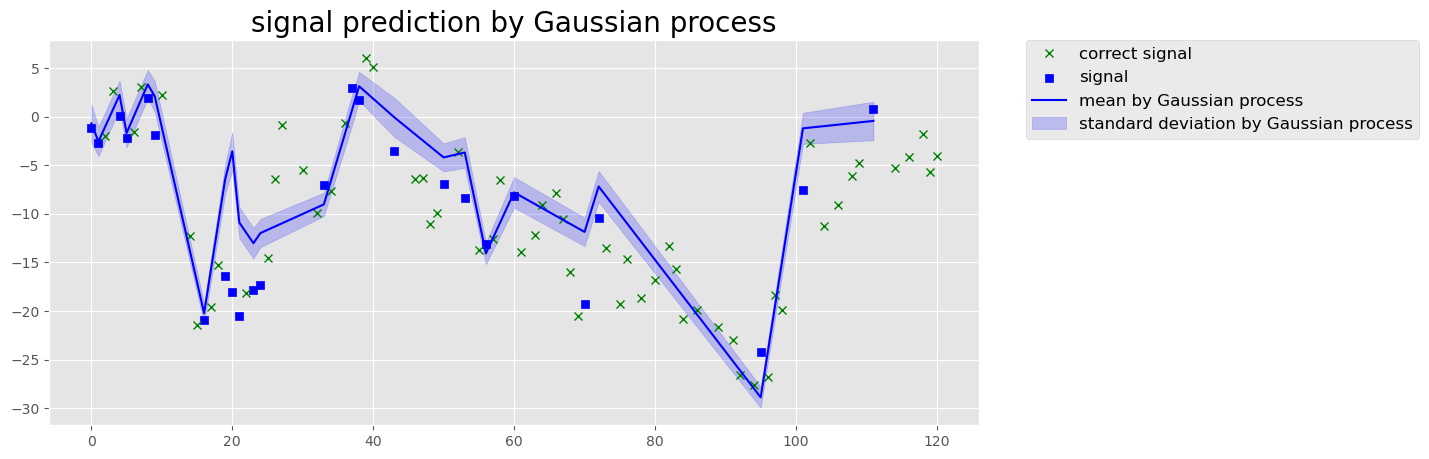

In [329]:
 Gaussian_result(X_train , y_train , X_test , y_test , mu , var )

ある程度予測が正しいところもありますが，できていないところも見受けられます．

### パラメータの学習
カーネルのモデル化はある程度的を得ているとして，パラメータを更新することでよりよいモデルを作っていくことを目指します．

方法は，交差検証データを用いて勾配法によるパラメータの更新をします．

In [330]:
D_cross.head() # 並び替えはしていない

,x,random_walk
2018-01-31,93,-30.064516
2017-07-31,87,-16.774194
2018-07-31,99,-22.806452
2016-09-30,77,-16.500000
2017-05-31,85,-19.354839


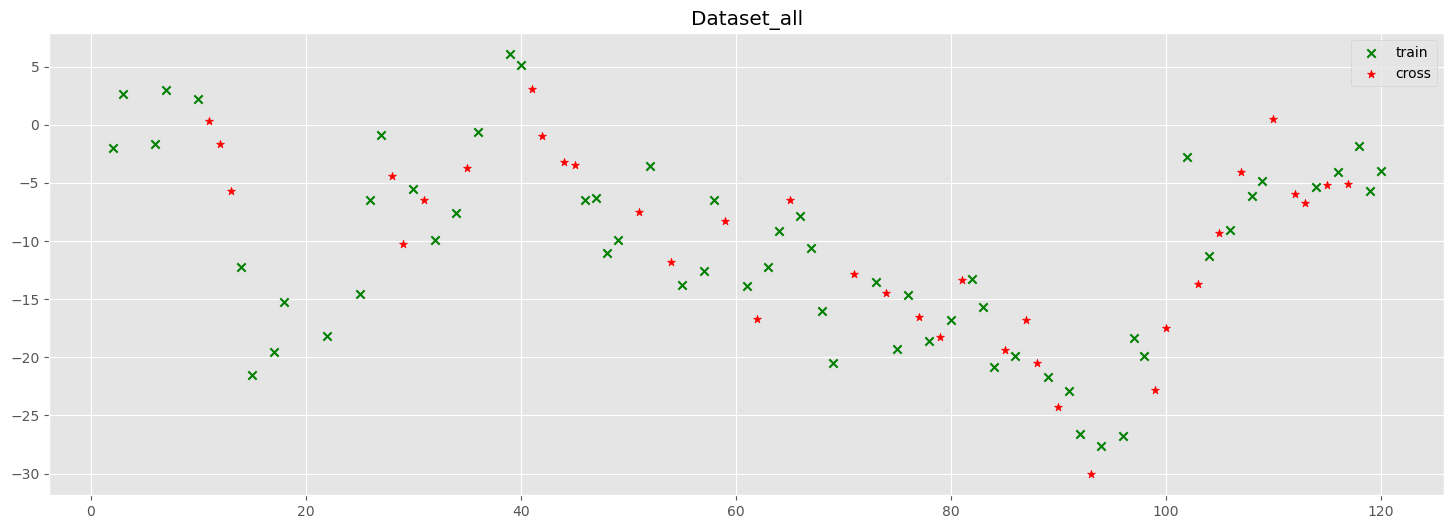

In [331]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(18, 6))

train_x = D_train["x"]
train_y = D_train["random_walk"]
cross_x = D_cross["x"]
cross_y = D_cross["random_walk"]
ax.scatter(train_x , train_y,marker='x' , label = 'train',color='green')
ax.scatter(cross_x , cross_y ,marker = '*' , label = 'cross' ,color='red')
ax.set_title("Dataset_all")

ax.legend()
plt.show()

$\tau = \log{\theta_1},\sigma = \log{\theta_2},\eta = \log{\theta_3} $として
$$
k(x , x^{'}) = e^{\tau} \exp{\left( - \frac{(x - x^{'})}{e^{\sigma}} \right)} + e^{\eta} \delta(x , x^{'})
$$

それぞれのカーネルに対する偏微分は
$$
\frac{\partial K_{(n,n^{'})}}{\partial \tau} =  K_{(n,n^{'})} - e^{\eta} \delta{(x , x^{'})}
$$ 
$$
\frac{\partial K_{(n,n^{'})}}{\partial \sigma} =  \left(K_{(n,n^{'})} - e^{\eta} \delta{(n,n^{'})} \right) e^{-\sigma}(x_n - x_{n^{'}})^2
$$ 
$$
\frac{\partial K_{(n,n^{'})}}{\partial \eta} =  e^{\eta} \delta{(x , x^{'})}
$$ 

これらの値を用いた更新式を確認しましょう．

$\tau$を具体例に，$l$を更新回数，$\alpha$を学習率として
$$
\tau^{(l)} = \tau^{(l - 1)} + \alpha  \frac{\partial L(\tau^{(l-1)},\sigma^{(l-1)},\eta^{(l-1)})}{\partial \tau^{(l-1)}}  
$$
$$
\frac{\partial L(\tau^{l-1},\sigma^{l-1},\eta^{l-1})}{\partial \tau^{l-1}}  = - \operatorname{tr}\left\{ K^{-1}_{\theta^{(l-1) }} \frac{\partial K^{-1}_{\theta^{(l-1)}}}{\partial \tau^{(l-1)}}\right\} + (K^{-1}_{\theta^{(l-1)}} \vec{y})^{\top} \frac{\partial K^{-1}_{\theta^{(l-1)}}}{\partial \tau^{(l-1)}} K^{-1}_{\theta^{(l-1)}} \vec{y}
$$
$$
\frac{\partial K^{-1}_{\theta^{(l-1)}}}{\partial \tau^{(l-1)}}=
K^{(l-1)} - \exp{(\eta^{(l-1)})} I
$$

In [332]:
X_cross , y_cross = D_cross["x"] , D_cross["random_walk"]
X_train , y_train = D_train["x"] , D_train["random_walk"]

In [333]:
X_train.shape , K.shape

((60,), (60, 60))

最初にカーネル行列の更新をするプログラムを作成します．

行列$X$やベクトル$y$などは更新しやすいですが，カーネル行列は大変だからです．

In [334]:
# カーネル行列の更新
def kernel_new(X_old , X_cross ,  l  , K_old ):
    l = l - 1
    train_length = len(X_old)
    length = train_length
    k = np.zeros(length)
    for x in range(train_length):
        k[x] = kernel(X_old[x], X_cross[l], Theta_1, Theta_2, Theta_3)
    K_new = np.vstack([K_old , k])
    
    s = kernel(X_cross[l], X_cross[l], Theta_1, Theta_2, Theta_3)
    k = np.append(k, s)
    k = k[:,np.newaxis]
    K_new = np.hstack([K_new , k])
    return K_new

次に対数尤度関数に対するパラメータの勾配を求めるプログラムを作成しましょう．

In [335]:
# tauの偏微分の計算
def Tau_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3):

    # X_train : (N + l - 1) × 1
    # K_old : (N + l - 1) × (N + l - 1)
    # y_old : (N + l - 1) × 1
    
    l = l
    old_length = len(X_old)
    length = old_length + l
    
    
    # パラメータの再定義
    tau , sig , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3)
    I = np.eye(length - l)
    yK = Expected_train(K_old , y_old)
    
    tau_grad = - 1 * np.trace( I - Theta_3 * np.linalg.inv(K_old)) + np.dot(yK , y_old) - Theta_3 * np.dot(yK , yK)
    return tau_grad

In [336]:
yK = Expected_train(K, y_train)
np.dot(yK , yK )

7321.703588806623

In [337]:
I = np.eye(len(X_train))
np.trace( I - Theta_3 * np.linalg.inv(K))

59.022182190633934

In [338]:
np.dot(yK , y_train)

7683.079545841634

In [339]:
# sigmaの偏微分の計算
def Distance_matrix(X_train):
    lenght = len(X_train)
    distance_matrix = np.zeros((lenght ,lenght))
    
    for x in range(lenght):
        for x_prime in range(lenght):
            X = X_train[x]
            X_prime = X_train[x_prime]
            distance_matrix[x , x_prime] = ( X - X_prime ) ** 2
    
    return distance_matrix

def New_distance_matrix( X_old ,  X_cross , l , distance_matrix_old ): # l：更新回数
    l = l - 1
    length = len(X_old)
    k = np.zeros(length)
    for x in range(length):
        X = X_old[x]
        X_prime = X_cross[l]
        k[x] = ( X - X_prime ) ** 2
    K_new = np.vstack([distance_matrix_old , k]) # 最後の行に追加
    
    s = 0
    k = np.append(k, s)
    k = k[:,np.newaxis] # (N + l - 1 ) × 1　の行列にする 
    distance_matrix_new = np.hstack([K_new , k]) # 最後の列に追加
    return distance_matrix_new

def Sigma_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3 , distance_matrix_old):
    # パラメータの再定義
    tau , sig , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3) 
    mai = 1 / Theta_2
    
    # 更新回数の確認
    l = l
    old_length = len(X_old)
    length = old_length + l
    
    d = distance_matrix_old
    yK = Expected_train(K_old , y_old)
    K_mai = np.linalg.inv(K_old)
    
    sigma_grad = - np.trace(mai * np.dot(K_mai,d) - Theta_3 * mai * np.dot(K_mai , d)) \
                + mai * np.dot( yK , np.dot( np.dot(K_old , d) , yK ) ) \
                - Theta_3 * mai * np.dot(yK , np.dot(d,yK)) 
    return sigma_grad 

In [340]:
d = Distance_matrix(X_train)
d

array([[0.0000e+00, 1.0000e+00, 1.6000e+01, ..., 1.3456e+04, 1.3689e+04,
        1.3924e+04],
       [1.0000e+00, 0.0000e+00, 9.0000e+00, ..., 1.3225e+04, 1.3456e+04,
        1.3689e+04],
       [1.6000e+01, 9.0000e+00, 0.0000e+00, ..., 1.2544e+04, 1.2769e+04,
        1.2996e+04],
       ...,
       [1.3456e+04, 1.3225e+04, 1.2544e+04, ..., 0.0000e+00, 1.0000e+00,
        4.0000e+00],
       [1.3689e+04, 1.3456e+04, 1.2769e+04, ..., 1.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.3924e+04, 1.3689e+04, 1.2996e+04, ..., 4.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [341]:
np.trace((1/Theta_2) * np.dot(np.linalg.inv(K),d) - Theta_3 * (1/Theta_2) * np.dot(np.linalg.inv(K) , d)) ,\
(1/Theta_2) * np.dot( yK , np.dot( np.dot(K , d) , yK ) ) , Theta_3 * ( 1 / Theta_2) * np.dot(yK , np.dot(d,yK)) 

(-16.68634776026554, 219891234.8478185, 1432783.5488768516)

In [342]:
# etaの偏微分の計算
def Eta_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3):
    # パラメータの再定義
    tau , sig , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3)
    # 学習回数の確認
    old_length = len(X_old)
    length = old_length + l
    # 計算に必要なベクトルK^{-1} * y
    yK = Expected_train(K_old , y_old)
    
    #　勾配の計算
    eta_grad = - Theta_3 * np.trace(np.linalg.inv(K_old)) + Theta_3 * np.dot(yK , yK)
    
    return eta_grad 

試しに最初の勾配を計算します．かなりでかいですね．

特にガウシアンカーネル部分の分散部分$\theta_2$は大きな影響を与えているようです．これはイメージ通りですね．

In [343]:
d = Distance_matrix(X_train)

In [344]:
tau_grad = Tau_grad(X_train , y_train  , K , 1,Theta_1 ,Theta_2 , Theta_3)
sigma_grad = Sigma_grad(X_train , y_train , K , 1 ,Theta_1 ,Theta_2 , Theta_3 , d)
eta_grad = Eta_grad(X_train , y_train , K , 1 ,Theta_1 ,Theta_2 , Theta_3)

tau_grad , sigma_grad , eta_grad

(7550.840327762933, 218458467.9852894, 72.23921807870018)

交差検証データの数だけ更新をし，学習済$\tau , \sigma , \eta$を計算しましょう．

In [345]:
def Parameter_new(X_train , X_cross, y_train , y_cross , K ,Theta_1 ,Theta_2 , Theta_3 , alpha):
    train_lenght = len(X_train)
    cross_lenght = len(X_cross)
    tau_history = np.zeros(cross_lenght)
    sigma_history = np.zeros(cross_lenght)
    eta_history = np.zeros(cross_lenght)
    
    #パラメータの初期値
    tau , sigma , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3)
    
    # 最初の引数を訓練データ，学習済みカーネルにする．
    X_old = X_train
    y_old = y_train
    K_old = K
    # sigmaの学習に必要な距離行列を定義しておく
    d = Distance_matrix(X_train)
    
    # 学習
    for l in range(cross_lenght):
        # パラメータの勾配計算
        tau_grad = Tau_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3)
        sigma_grad = Sigma_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3 , d)
        eta_grad = Eta_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3)
        # パラメータの更新
        tau = tau - alpha * tau_grad
        sigma = sigma - alpha * sigma_grad
        eta = eta - alpha * eta_grad
        # パラメータの軌跡保存
        tau_history[l] = tau 
        tau_history[l] = tau 
        tau_history[l] = tau 
        # X,y,kernel,dの更新
        K_old = kernel_new(X_old , X_cross , l , K_old )
        d = New_distance_matrix( X_old ,  X_cross , l , d )
        X_old = np.append(X_old , X_cross[l])
        y_old = np.append(y_old , y_cross[l])
    
    Theta_1_new = np.exp(tau)
    Theta_2_new = np.exp(sigma)
    Theta_3_new = np.exp(eta)
        
    return tau , tau_history , sigma , sigma_history , eta , eta_history , Theta_1_new , Theta_2_new , Theta_3_new 

試してみましょう．

In [346]:
%time tau , tau_history , sigma , sigma_history , eta , eta_history , Theta_1_new , Theta_2_new , Theta_3_new  = \
Parameter_new(X_train , X_cross, y_train , y_cross , K ,Theta_1 ,Theta_2 , Theta_3 , alpha) 
print("-----------------------------")
print("初期パラメータは")
print(Theta_1)
print(Theta_2)
print(Theta_3)
print("-----------------------------")
print("学習率は")
print(alpha)
print("学習済みパラメータは")
print(Theta_1_new)
print(Theta_2_new)
print(Theta_3_new)

CPU times: user 718 ms, sys: 15.2 ms, total: 733 ms
Wall time: 149 ms
-----------------------------
初期パラメータは
1.0
2.0
0.01
-----------------------------
学習率は
7.5e-13
学習済みパラメータは
1.0000141173179575
1.9904380638107453
0.009999855839296355


### テストデータへのあてはめ（再）
学習済みパラメータを用いて，もう一度テストデータにあてはめましょう．

In [347]:
mu_new , var_new = predict(X_train , X_test , Theta_1_new , Theta_2_new , Theta_3_new) 

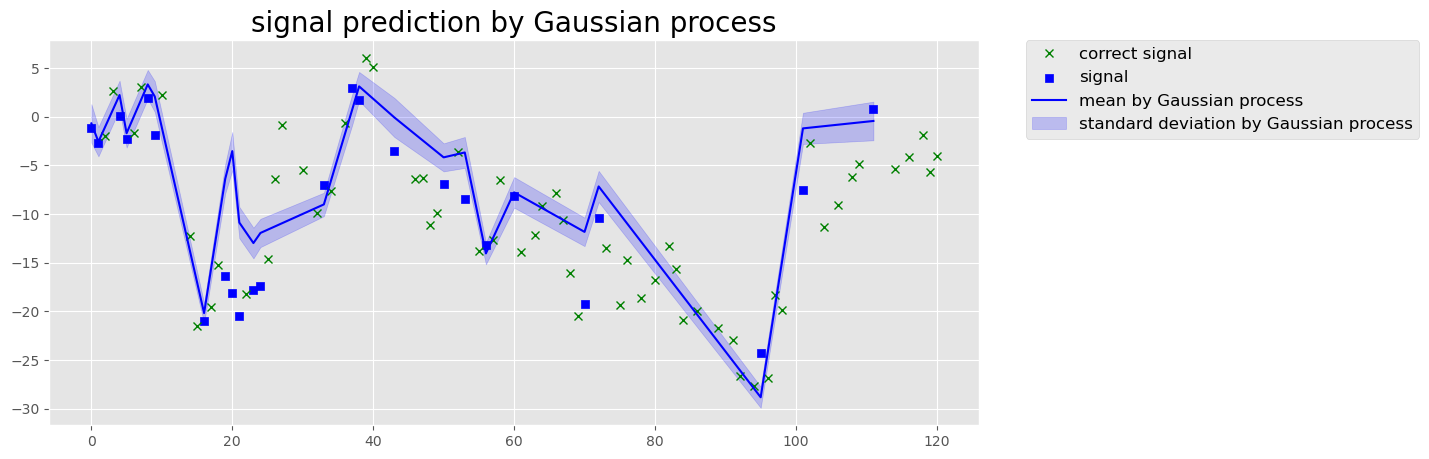

In [348]:
# 学習済み 
Gaussian_result(X_train , y_train , X_test , y_test , mu_new , var_new )

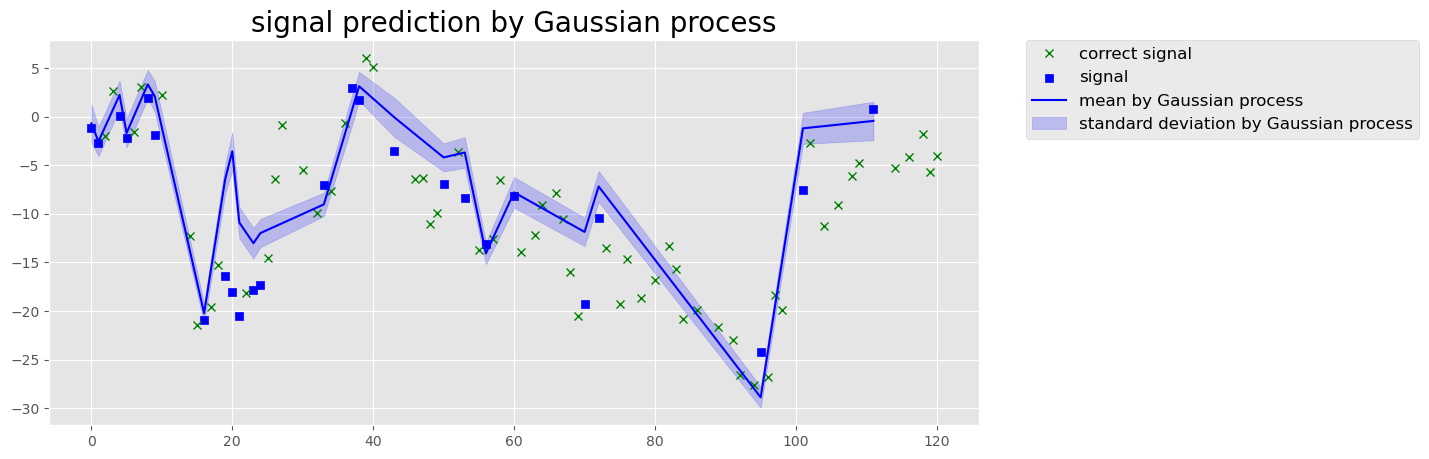

In [349]:
# 初期 
Gaussian_result(X_train , y_train , X_test , y_test , mu , var )

# 追加2023/5/9
# ランダムウォークの理論的な分散共分散行列を計算した上でのモデル化

## モデルの新しい構築
計算結果から導き出されるカーネルは，以下のようになる．


$$
K^{(ideal) } = 
\frac{2}{3}
\begin{pmatrix}
1 & 1 & 1 & ・・・ & 1 \\
1 & 2 & 2 & ・・・ & 2 \\
1 & 2 & 3 & ・・・ & 3 \\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
1 & 2 & 3 & ・・・ & T \\
\end{pmatrix}
$$
このことを参考に，以下のカーネルでモデル化を行う．

$$
k(x , x^{\prime}) = \theta_1 \exp{\left( - \frac{(x - x^{\prime})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{\prime}) + \theta_4 \min{\{x , x^{\prime}\}}
$$
### 学習データからカーネルを学習

In [350]:
# パラメータ値
Theta_1 = 0.1
Theta_2 = 3.0
Theta_3 = 0.1
Theta_4 = 10.0


In [351]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r, o):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    if x > x_prime:
        a = x_prime
    else:
        a = x
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) + o * a
    return kernel

In [352]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3, Theta_4):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3 , Theta_4)
    return K

In [353]:
%time  K = compute_kernel(X_train , Theta_1 , Theta_2 , Theta_3 , Theta_4)
K.shape

CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 23.5 ms


(60, 60)

In [354]:
K

array([[  20.2       ,   20.07165313,   20.00048279, ...,   20.        ,
          20.        ,   20.        ],
       [  20.07165313,   30.2       ,   30.00497871, ...,   30.        ,
          30.        ,   30.        ],
       [  20.00048279,   30.00497871,   60.2       , ...,   60.        ,
          60.        ,   60.        ],
       ...,
       [  20.        ,   30.        ,   60.        , ..., 1180.2       ,
        1180.07165313, 1180.02635971],
       [  20.        ,   30.        ,   60.        , ..., 1180.07165313,
        1190.2       , 1190.07165313],
       [  20.        ,   30.        ,   60.        , ..., 1180.02635971,
        1190.07165313, 1200.2       ]])

In [355]:
# K^{-1} * y を計算する関数
def Expected_train(K , y):
    yy = np.dot(np.linalg.inv(K), y) # np.linalg.invは逆行列
    return yy

In [356]:
np.linalg.inv(K)

array([[ 1.45777293e-01, -9.66084118e-02, -2.41168948e-04, ...,
        -7.23011026e-18, -3.86614277e-18, -1.27226409e-18],
       [-9.66084118e-02,  1.29621083e-01, -3.21549662e-02, ...,
        -1.64871561e-18,  6.45164756e-18, -3.59915686e-19],
       [-2.41168948e-04, -3.21549662e-02,  1.29619195e-01, ...,
         5.19206542e-18, -3.27552247e-18, -7.97021396e-18],
       ...,
       [-1.23286336e-50, -5.23245860e-49, -7.70295629e-48, ...,
         1.45631748e-01, -9.64025080e-02, -5.91837489e-04],
       [-3.91374233e-51, -1.66105145e-49, -2.44531447e-48, ...,
        -9.64025080e-02,  1.93430472e-01, -9.67128469e-02],
       [-1.15234115e-51, -4.89071017e-50, -7.19985184e-49, ...,
        -5.91837489e-04, -9.67128469e-02,  9.75045210e-02]])

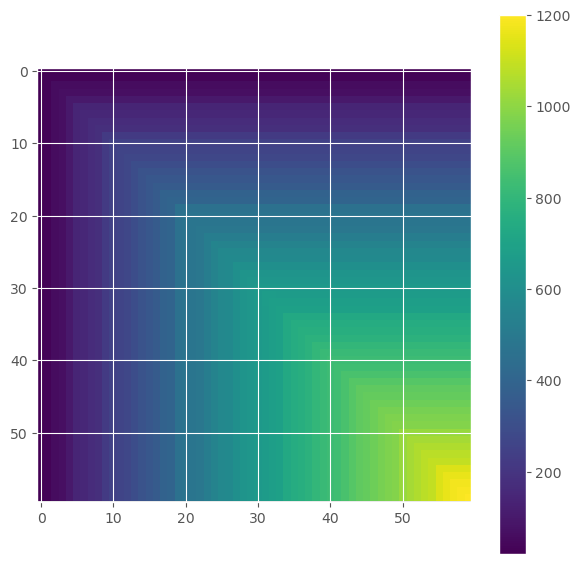

In [357]:
fig, axes = plt.subplots(figsize=(7, 7))
im = axes.imshow(K)
fig.colorbar(im, ax=axes)
plt.show()

### テストデータへの当てはめ
予測したいテストデータ$X^{*} = (x^{*}_1 , ... ,x^{*}_M)$と予測したい出力 $\vec{y}^{*} = (y^{*}_1 , ... ,y^{*}_M)$とする．

教科書P84の公式3.8より$\vec{y}^{*}$の予測分布は
$$
p(y^{*} | X^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$

期待値と分散をそれぞれ計算することで，上の予測分布を計算することができます．

最終的なプロットに必要なのは分散のみで共分散は不要です．

In [358]:
def predict(X_train , y_train , X_test , Theta_1 , Theta_2 , Theta_3 , Theta_4 , K) :
    # 平均
    mu = []
    # 分散
    var = []

    # K^{-1} * y を計算する関数
    yy = Expected_train(K , y_train)

    train_length = len(X_train)
    test_length = len(X_test)
    for x_test in range(test_length):

    # テストデータとトレーニングデータ間のカーネル行列の下地を準備
        k = np.zeros(train_length)
        for x in range(train_length):
            
            # 訓練データとテストデータのカーネル
            k[x] = kernel(X_train[x], X_test[x_test], Theta_1, Theta_2, Theta_3 , Theta_4) # (3.68)式
            
            #テストデータ同士のカーネル
        s = kernel(X_test[x_test], X_test[x_test], Theta_1, Theta_2, Theta_3 , Theta_4 ) # (3.69)式

    # 内積はドットで計算して, 平均値の配列に追加
        mu.append(np.dot(k, yy)) # (3.74)式の期待値
    
    # 先に『k * K^-1』の部分を(内積なのでドットで)計算
        kK_ = np.dot(k, np.linalg.inv(K)) 
    
    # 後半部分との内積をドットで計算して, 分散の配列に追加
        var.append(s - np.dot(kK_, k.T)) # (3.74)式の分散
    
    return mu , var

In [359]:
mu , var = predict(X_train , y_train , X_test , Theta_1 , Theta_2 , Theta_3 , Theta_4 , K)

In [360]:
# ガウス過程回帰の結果をプロットする関数
def Gaussian_result(X_train , y_train , X_test , y_test , mu , var ):
    # 分散を標準偏差に変換
    std = np.sqrt(var)
    
    plt.figure(figsize=(12, 5))
    plt.title('signal prediction by Gaussian process', fontsize=20)
    
    # 元の信号
    plt.plot(X_train ,y_train, 'x', color='green', label='correct signal')
    # 正解のプロット
    plt.scatter(X_test, y_test , marker='s' , color='blue', label='signal')
    # ガウス過程で求めた平均値を信号化
    plt.plot(X_test, mu, color='blue', label='mean by Gaussian process')
    
    # ガウス過程で求めた標準偏差を範囲化 alphaは透明度
    plt.fill_between(X_test, mu + 2 * std, mu - 2 * std, alpha=0.2, color='blue', label= 'standard deviation by Gaussian process')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.show()

    # 平均値±(標準偏差×2) … 95%の確率で範囲内に指定の数値が現れる

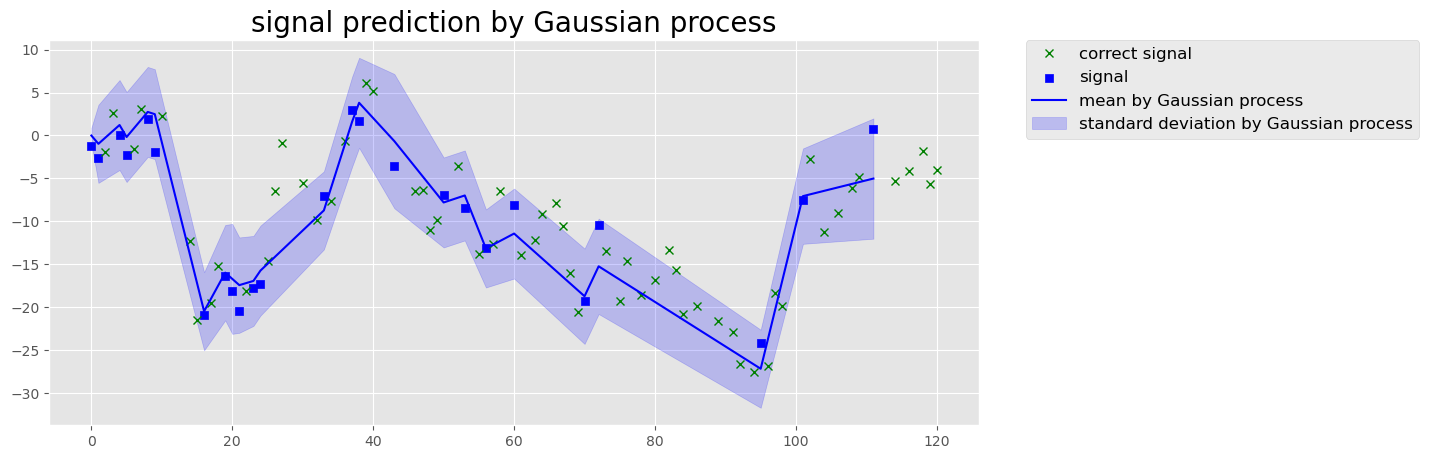

In [361]:
Gaussian_result(X_train , y_train , X_test , y_test , mu , var )